In [1]:
# Standard Library Imports
import os
import glob

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Local imports
from fault.fault import Fault
from fault.io.fsp import read_from_file
from fault.io.timeseries import read_from_directory

%matplotlib inline

# Quick Plotting of Rupture Grids
Plots are created by finding the maximum area under a grid created using the convolution of the slip, as outlined on [page 4](https://www.researchgate.net/profile/P_Mai/publication/228607551_Source_scaling_properties_from_finite-fault-rupture_models/links/591b21e9a6fdcc701fd172f1/Source-scaling-properties-from-finite-fault-rupture-models.pdf):

$$ \frac{\int^\infty_{-\infty} (f*f) dx}{f*f|_{x=0}} $$

## Libcomcat request
The following bash command will get fsp products from libcomcat. The current command will get 172 products, which takes around 5-10 minutes. Limiting times and magnitude for a smaller request is recommended.

Note: bash script magic only works on Linux and MacOS.

In [ ]:
%%bash
$(find ~/ -name getproduct | head -n 1) finite-fault .fsp -o /tmp/fsp_from_libcomcat -s 1980-01-01 -e 2018-04-18 -m 6 10 

This command produces one product:

In [2]:
%%bash
$(find ~/ -name getproduct | head -n 1) finite-fault .fsp -o /tmp/fsp_from_libcomcat -s 2018-01-09 -e 2018-01-11 -m 7.5 8

Downloaded us1000c2zy .fsp to /tmp/fsp_from_libcomcat/us1000c2zy/us1000c2zy_us_1_1000c2zy.fsp


In [3]:
# Group files in /tmp/fsp_from_libcomcat
fsp_locations = []
directory = os.getcwd()
for file_path in glob.glob('/tmp/fsp_from_libcomcat/*/*.fsp'):
        fsp_locations += [file_path]

-----------------------------------------------------------------------------



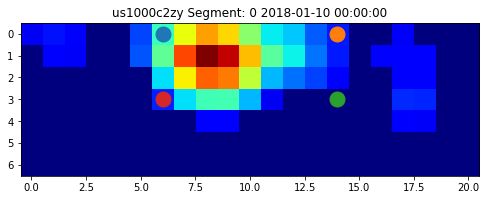

In [4]:
for fspfile in fsp_locations:
    # Get filename and initialize plotting objects
    fsp = Fault.fromFsp(fspfile)
    fig = plt.figure(figsize=(20, 10))
    counter = 0;
    print('-----------------------------------------------------------------------------\n')
    # Loop through segments
    for num in range(fsp.getNumSegments()):
        # Get segment
        segment = fsp.getSegment(num)
        
        # Threshold slip
        thresholded_slip = fsp.thresholdSlip(segment['slip'])
        
        # Sum rows and columns
        sum_rows, sum_columns = fsp.sumSlip(thresholded_slip)
        
        # Autocorrelate summed rows and columns
        autocorrelated_rows, autocorrelated_columns = fsp.autocorrelateSums(sum_rows,sum_columns)
        
        # Get rupture dimensions
        rupture_length, rupture_width = fsp.getRuptureSize(autocorrelated_rows, autocorrelated_columns)
        
        # Get min and max of rupture in two directions
        left, right, top, bottom = fsp.getRuptureGrid(rupture_length, 
                        rupture_width, thresholded_slip, segment['length'],
                        segment['width'])
        
        # Get corners as coordinates for primary segment
        if num == 0:
            corners = fsp.getCornerCoordinates(left, right, top, bottom, segment['lon'], segment['lat'])
        
        # Plot thresholded slip and grid corners
        counter += 1
        plt.subplot(np.ceil(fsp.getNumSegments()/3), 3, counter)
        plt.imshow(thresholded_slip, cmap='jet', interpolation='none')
        plt.plot(left, top,'o',markersize=15)
        plt.plot(right, top,'o',markersize=15)
        plt.plot(right, bottom,'o',markersize=15)
        plt.plot(left, bottom,'o',markersize=15)
        dirstr = fspfile.split('/')[-2]
        plt.title(dirstr + ' Segment: ' + str(num) + ' ' + str(fsp._event['date']), fontsize=12)
        
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
    
    # plot primary segment 
    #ax = plt.axes(projection=ccrs.PlateCarree())
    #ax.stock_img()
    #for key in corners:
    #    coords = corners[key]
    #    ax.scatter([coords[0]],
    #       [coords[1]])
    #    ax.set_xmargin(0.05)
    #    ax.set_ymargin(0.10)

## To delete files:
%%bash

rm -r /tmp/fsp_from_libcomcat